In [166]:
# Importing Dependencies 
import numpy as np
import pandas as pd
import librosa 

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import seaborn as sns

from scipy.stats import gaussian_kde

from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge, Perceptron, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from mlxtend.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline as IMBPipeline

from sklearn.metrics import root_mean_squared_error

In [73]:
# data paths
DEV_DATA_PATH = "data/development.csv"   
EVAL_DATA_PATH = "data/evaluation.csv"  

In [74]:
# load datasets
df_dev = pd.read_csv(DEV_DATA_PATH) 
df_eval = pd.read_csv(EVAL_DATA_PATH)

In [75]:
def preprocess_and_transform_columns(df):
    df = df.rename(columns={"age": "target"})  # Rename 'age' to 'target'
    df = df.drop(columns=["Id", "sampling_rate", "path"])  # Remove unnecessary columns
    df["tempo"] = df["tempo"].apply(lambda x: float(x[1:-1]))  # Transform 'tempo' values
    df["gender"] = df["gender"].replace("famale", "female")
    return df


df_dev = preprocess_and_transform_columns(df_dev)
df_eval = preprocess_and_transform_columns(df_eval)

In [76]:
df_dev_copy = df_dev.copy()
df_eval_copy = df_eval.copy()

In [77]:
print(df_dev_copy.info())  # summary of the DataFrame
display(df_dev_copy.head())  # first few rows of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   target                  2933 non-null   float64
 1   gender                  2933 non-null   object 
 2   ethnicity               2933 non-null   object 
 3   mean_pitch              2933 non-null   float64
 4   max_pitch               2933 non-null   float64
 5   min_pitch               2933 non-null   float64
 6   jitter                  2933 non-null   float64
 7   shimmer                 2933 non-null   float64
 8   energy                  2933 non-null   float64
 9   zcr_mean                2933 non-null   float64
 10  spectral_centroid_mean  2933 non-null   float64
 11  tempo                   2933 non-null   float64
 12  hnr                     2933 non-null   float64
 13  num_words               2933 non-null   int64  
 14  num_characters          2933 non-null   

,target,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,281,39,23.846893
1,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,281,21,19.388662
2,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,281,1,21.640998
3,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,281,9,19.644127
4,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,281,11,18.041905


In [78]:
print(df_eval_copy.info())
display(df_eval_copy.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  691 non-null    object 
 1   ethnicity               691 non-null    object 
 2   mean_pitch              691 non-null    float64
 3   max_pitch               691 non-null    float64
 4   min_pitch               691 non-null    float64
 5   jitter                  691 non-null    float64
 6   shimmer                 691 non-null    float64
 7   energy                  691 non-null    float64
 8   zcr_mean                691 non-null    float64
 9   spectral_centroid_mean  691 non-null    float64
 10  tempo                   691 non-null    float64
 11  hnr                     691 non-null    float64
 12  num_words               691 non-null    int64  
 13  num_characters          691 non-null    int64  
 14  num_pauses              691 non-null    in

,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,male,spanish,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,80.749512,-116.662338,69,281,2,38.198503
1,male,xiang,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,89.102909,-78.253824,69,281,27,29.605442
2,male,igbo,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,123.046875,-71.630742,6,22,2,2.275556
3,female,spanish,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,123.046875,-101.533013,69,281,31,22.151837
4,male,spanish,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,112.347147,-134.914070,69,281,35,22.430476


# EDA

In [79]:
display(df_dev_copy.describe(include="all").T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
target,2933.0,NaN,NaN,NaN,27.897886,13.093316,6.0,19.0,23.0,32.0,97.0
gender,2933,2,female,1468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,2933,165,igbo,1081,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_pitch,2933.0,NaN,NaN,NaN,1189.536569,414.193673,346.97433,818.92236,1208.9983,1523.7777,2724.8928
max_pitch,2933.0,NaN,NaN,NaN,3779.570485,532.847869,935.51556,3948.2344,3998.3972,3999.4854,3999.7925
min_pitch,2933.0,NaN,NaN,NaN,146.93493,3.757917,145.34914,145.41914,145.62201,146.82089,202.0407
jitter,2933.0,NaN,NaN,NaN,0.02119,0.006626,0.007292,0.016734,0.020525,0.024558,0.096153
shimmer,2933.0,NaN,NaN,NaN,0.107741,0.029005,0.045205,0.087378,0.104697,0.124993,0.265167
energy,2933.0,NaN,NaN,NaN,0.005208,0.006074,0.000028,0.00196,0.003716,0.006338,0.129114
zcr_mean,2933.0,NaN,NaN,NaN,0.104774,0.051646,0.015947,0.060733,0.098964,0.139559,0.335976


In [80]:
display(df_eval_copy.describe(include="all").T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,691,2,male,393,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,691,73,igbo,232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_pitch,691.0,NaN,NaN,NaN,1191.041077,379.826928,419.39615,865.61758,1209.6804,1487.32605,2201.411
max_pitch,691.0,NaN,NaN,NaN,3832.21458,451.201809,1151.0122,3955.64905,3998.6313,3999.52185,3999.7908
min_pitch,691.0,NaN,NaN,NaN,146.591685,3.212186,145.34923,145.401825,145.52914,146.39692,186.68895
jitter,691.0,NaN,NaN,NaN,0.02132,0.006399,0.009395,0.017184,0.02067,0.024536,0.07745
shimmer,691.0,NaN,NaN,NaN,0.110438,0.029365,0.035001,0.089501,0.106233,0.126537,0.246068
energy,691.0,NaN,NaN,NaN,0.005074,0.00543,0.000056,0.001851,0.003582,0.006147,0.048074
zcr_mean,691.0,NaN,NaN,NaN,0.105111,0.050162,0.018496,0.064549,0.098416,0.135834,0.335676
spectral_centroid_mean,691.0,NaN,NaN,NaN,2214.701841,571.250581,803.534172,1785.536118,2174.406614,2580.589333,4753.076563


## Target data

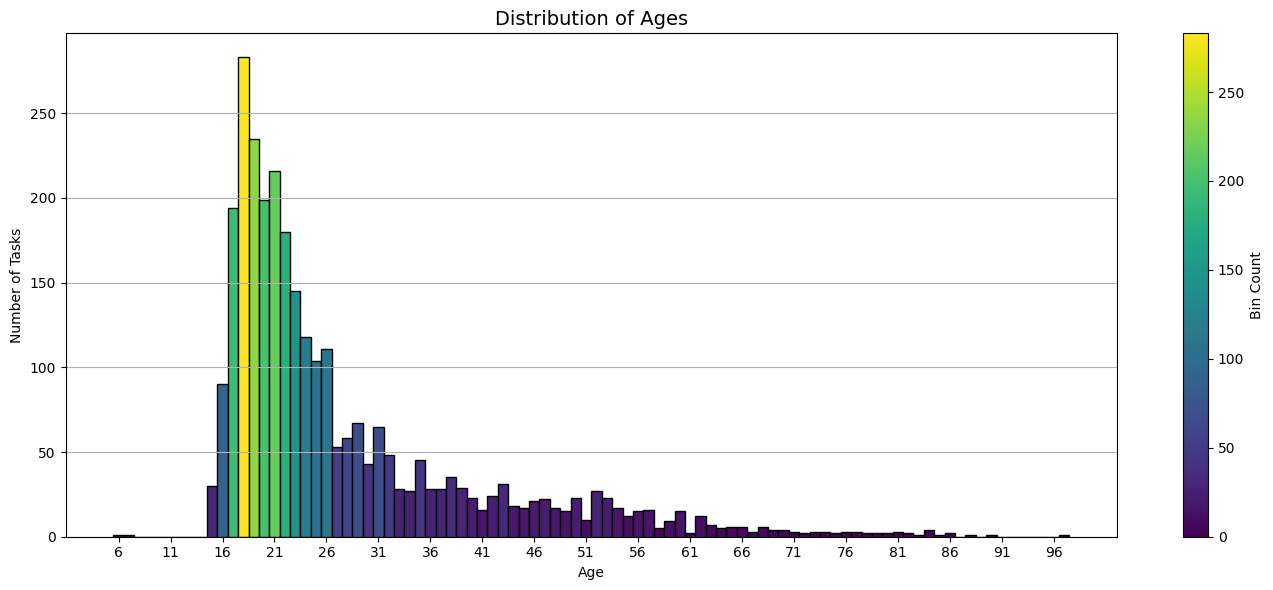

In [82]:
# collect target data
target = df_dev_copy["target"].copy()
# define bins such that each bin represents one year
bins = np.arange(target.min() - 0.5, target.max() + 1.5, 1)

fig, ax = plt.subplots(figsize=(14, 6))
N, bins, patches = ax.hist(target, bins=bins, edgecolor="black", align='mid')

# create a normalizer from bin counts
norm = mcolors.Normalize(vmin=N.min(), vmax=N.max())
cmap = cm.viridis

# color each bin patch based on its count
for count, patch in zip(N, patches):
    patch.set_facecolor(cmap(norm(count)))

ax.set_title("Distribution of Ages", fontsize=14)
ax.set_xlabel("Age")
ax.set_ylabel("Number of Tasks")
ax.set_xticks(range(int(target.min()), int(target.max()) + 1, 5))
ax.grid(axis='y')


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([]) 
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Bin Count")

fig.tight_layout()
plt.show()


## Categorical Data

### Gender (Dev v.s. Eval)

In [83]:
dev_gender = df_dev_copy["gender"].copy()
eval_gender = df_eval_copy["gender"].copy()

dev_labels, dev_sizes = dev_gender.value_counts().index, dev_gender.value_counts().values
eval_labels, eval_sizes = eval_gender.value_counts().index, eval_gender.value_counts().values

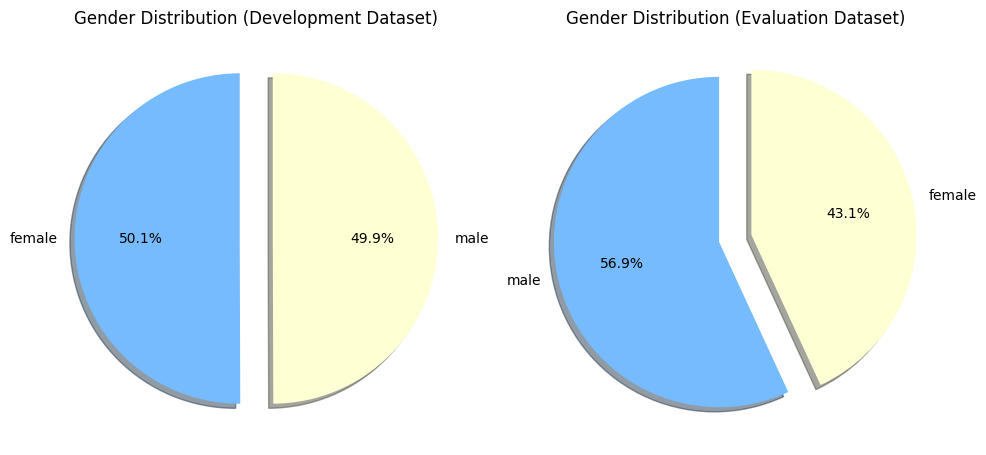

In [84]:
# define a colormap for consistent coloring
pie_colors = ["xkcd:sky blue", "xkcd:eggshell"]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Development dataset pie chart
axes[0].pie(dev_sizes, labels=dev_labels, autopct='%1.1f%%', 
            explode=[0.1] * len(dev_labels), shadow=True, startangle=90, colors=pie_colors)
axes[0].set_title("Gender Distribution (Development Dataset)")

# Development dataset pie chart
axes[1].pie(eval_sizes, labels=eval_labels, autopct='%1.1f%%', 
            explode=[0.1] * len(eval_labels), shadow=True, startangle=90, colors=pie_colors)
axes[1].set_title("Gender Distribution (Evaluation Dataset)")

plt.tight_layout()
plt.show()

### Age Distribution Among Genders

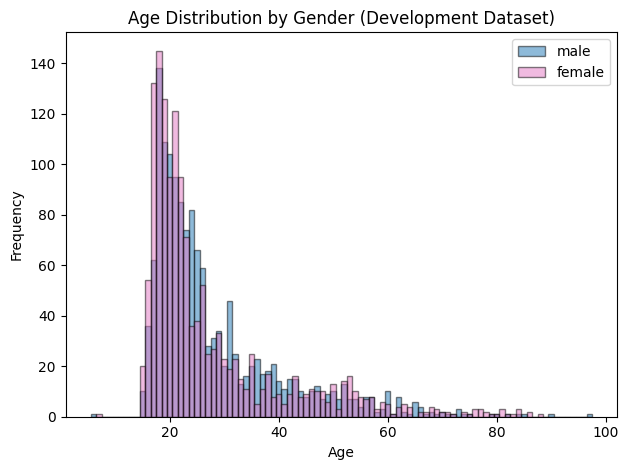

In [85]:
age_male = target[df_dev_copy["gender"] == "male"]
age_female = target[df_dev_copy["gender"] == "female"]

# bins for both distributions
bins = np.arange(min(age_male.min(), age_female.min()) - 0.5, 
                 max(age_male.max(), age_female.max()) + 1.5, 1)

plt.hist(age_male, bins=bins, edgecolor="black", align="mid", color="tab:blue", alpha=.5, label="male")
plt.hist(age_female, bins=bins, edgecolor="black", align="mid", color="tab:pink", alpha=.5, label="female")

plt.title("Age Distribution by Gender (Development Dataset)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

### Ethnicity

In [86]:
dev_ethnicity = df_dev_copy["ethnicity"]
eval_ethnicity = df_eval_copy["ethnicity"]

dev_unique_ethnicity = set(dev_ethnicity.unique())
eval_unique_ethnicity = set(eval_ethnicity.unique())

print(f"Number of different ethnicities in development dataset: {len(dev_unique_ethnicity)}")
print(f"Number of different ethnicities in evaluation dataset: {len(eval_unique_ethnicity)}")

common_ethnicities = dev_unique_ethnicity & eval_unique_ethnicity
print(f"Number of common ethnicities between development and evaluation set: {len(common_ethnicities)}")

Number of different ethnicities in development dataset: 165
Number of different ethnicities in evaluation dataset: 73
Number of common ethnicities between development and evaluation set: 17


In [87]:
print(f"{'Ethnicity':<15}{'Development Set':<20}{'Evaluation Set':<20}")
print("-" * 55)

for ethnicity in common_ethnicities:
    dev_n_instances = (df_dev_copy["ethnicity"] == ethnicity).sum()
    eval_n_instances = (df_eval_copy["ethnicity"] == ethnicity).sum()
    print(f"{ethnicity:<15}{dev_n_instances:<20}{eval_n_instances:<20}")


Ethnicity      Development Set     Evaluation Set      
-------------------------------------------------------
kanuri         1                   4                   
afemai         2                   1                   
hausa          11                  1                   
congolese      13                  1                   
ukwani         2                   1                   
ikwerre        2                   1                   
igala          22                  4                   
nigerian       5                   1                   
yoruba         12                  5                   
ibibio         27                  2                   
urhobo         32                  1                   
igbo           1081                232                 
indian         2                   2                   
ijaw           2                   1                   
cameroonian    2                   1                   
annang         2                   2            

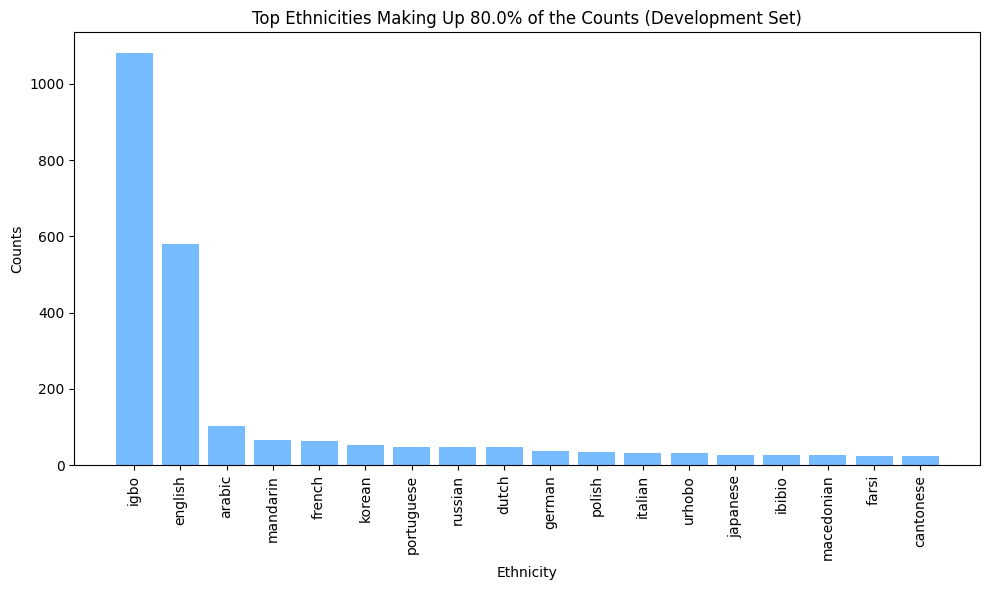

In [88]:
# Calculate counts and labels
dev_ethnicity_counts, dev_ethnicity_labels = dev_ethnicity.value_counts().values, dev_ethnicity.value_counts().index

# Compute cumulative sum and filter based on the 80% threshold
total = dev_ethnicity_counts.sum()
cumulative = dev_ethnicity_counts.cumsum()

perc = 0.80
filter_mask = cumulative <= total * perc

# Filter the counts and labels
dev_reduced_ethnicity_counts = dev_ethnicity_counts[filter_mask]
dev_reduced_ethnicity_labels = dev_ethnicity_labels[filter_mask]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(dev_reduced_ethnicity_labels, dev_reduced_ethnicity_counts, color='xkcd:sky blue')
ax.set_xticks(range(len(dev_reduced_ethnicity_labels)))
ax.set_xticklabels(dev_reduced_ethnicity_labels, rotation=90)
ax.set_xlabel("Ethnicity")
ax.set_ylabel("Counts")
ax.set_title(f"Top Ethnicities Making Up {perc * 100}% of the Counts (Development Set)")
plt.tight_layout()
plt.show()

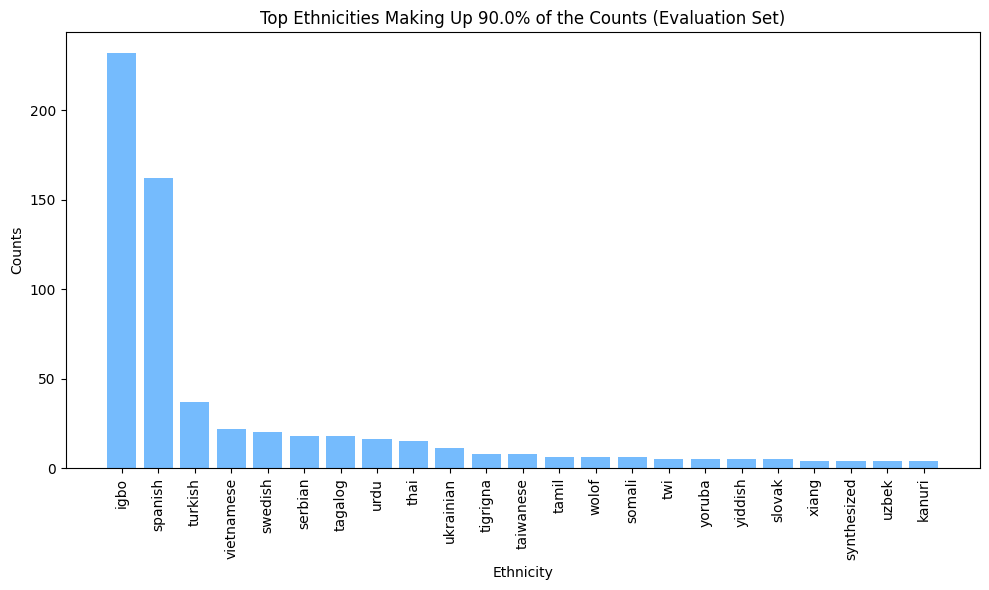

In [89]:
# Calculate counts and labels
eval_ethnicity_counts, eval_ethnicity_labels = eval_ethnicity.value_counts().values, eval_ethnicity.value_counts().index

# Compute cumulative sum and filter based on the 80% threshold
total = eval_ethnicity_counts.sum()
cumulative = eval_ethnicity_counts.cumsum()

perc = 0.9
filter_mask = cumulative <= total * perc

# Filter the counts and labels
eval_reduced_ethnicity_counts = eval_ethnicity_counts[filter_mask]
eval_reduced_ethnicity_labels = eval_ethnicity_labels[filter_mask]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(eval_reduced_ethnicity_labels, eval_reduced_ethnicity_counts, color='xkcd:sky blue')
ax.set_xticks(range(len(eval_reduced_ethnicity_labels)))
ax.set_xticklabels(eval_reduced_ethnicity_labels, rotation=90)
ax.set_xlabel("Ethnicity")
ax.set_ylabel("Counts")
ax.set_title(f"Top Ethnicities Making Up {perc * 100}% of the Counts (Evaluation Set)")
plt.tight_layout()
plt.show()

## Numerical Data

### Provided Features

In [90]:
NUMERICAL_FEATURES = [column for column in df_dev_copy.columns if (df_dev_copy[column].dtype == "float") & (column != "target")]

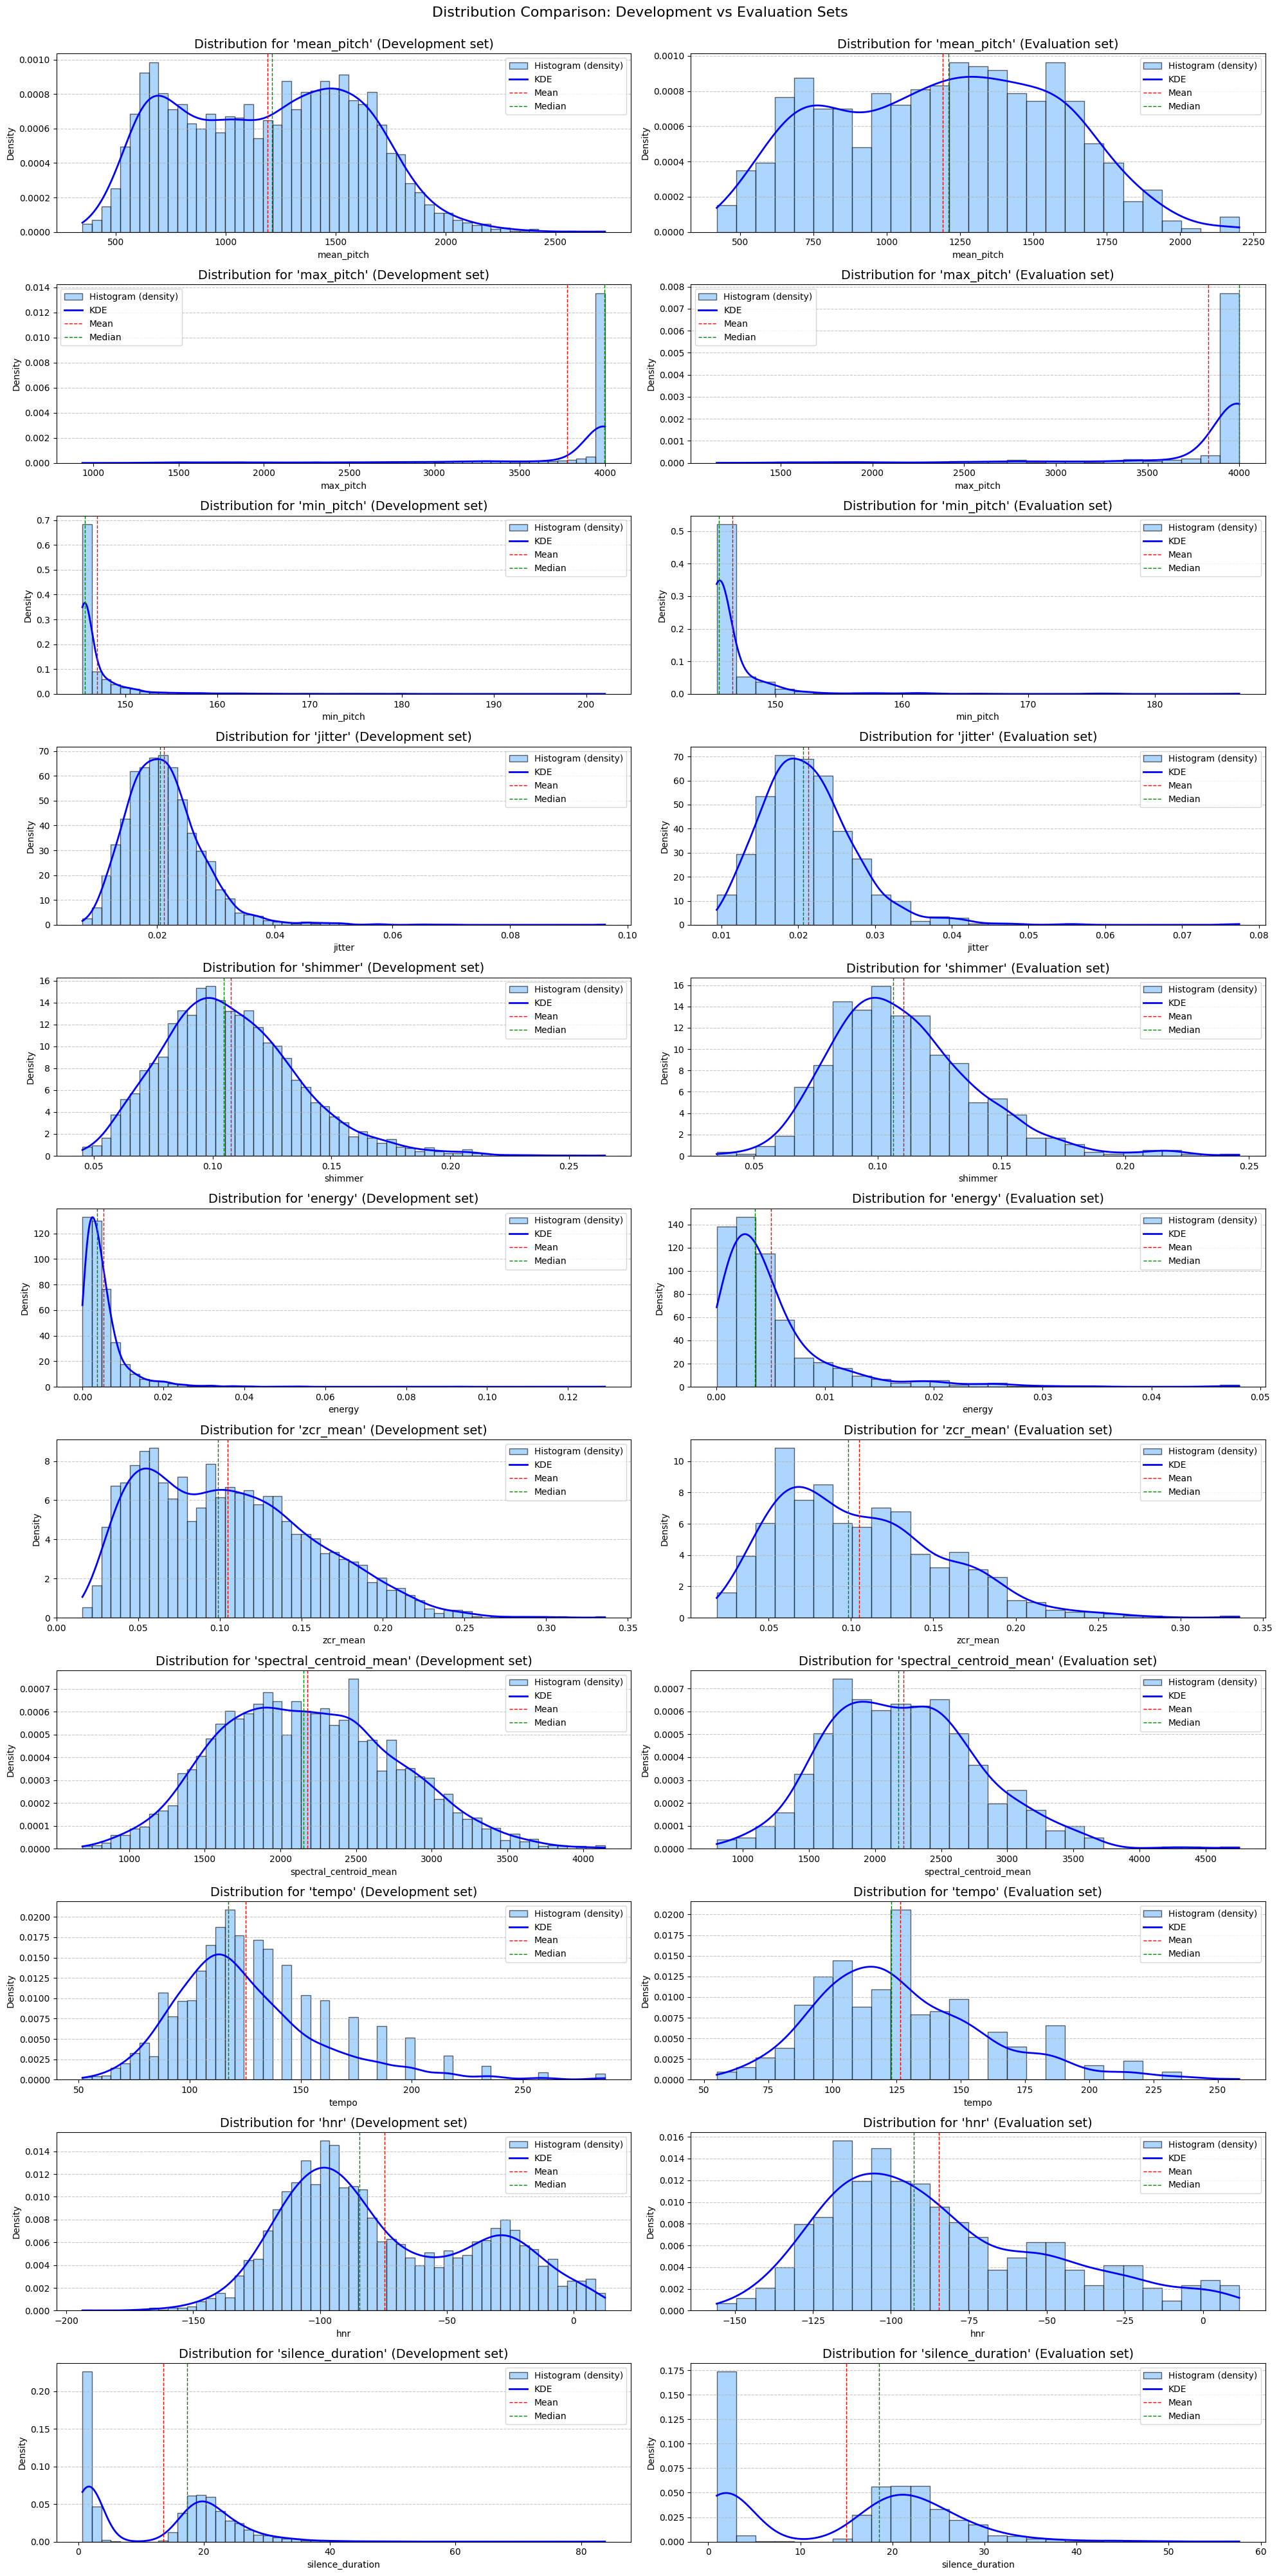

In [91]:
n_rows = len(NUMERICAL_FEATURES)

fig, axes = plt.subplots(n_rows, 2, figsize=(20, 40))

for i, feature in enumerate(NUMERICAL_FEATURES):
    # extract relative data
    dev_data = df_dev_copy[feature]
    eval_data = df_eval_copy[feature]

    # plot for dev set
    axes[i, 0].hist(dev_data, bins="sqrt", density=True, edgecolor="black", alpha=0.6, color="xkcd:sky blue", label="Histogram (density)")
    kde = gaussian_kde(dev_data)
    x_vals = np.linspace(dev_data.min(), dev_data.max(), dev_data.shape[0])
    y_vals = kde(x_vals)
    axes[i, 0].plot(x_vals, y_vals, color='blue', linewidth=2, label='KDE')

    mean_val = dev_data.mean()
    median_val = dev_data.median()
    axes[i, 0].axvline(mean_val, color='red', linestyle='--', linewidth=1, label='Mean')
    axes[i, 0].axvline(median_val, color='green', linestyle='--', linewidth=1, label='Median')

    axes[i, 0].set_title(f"Distribution for '{feature}' (Development set)", fontsize=14)
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel("Density")
    axes[i, 0].legend()
    axes[i, 0].grid(axis='y', linestyle='--', alpha=0.7)


    # plot for eval set
    axes[i, 1].hist(eval_data, bins="sqrt", density=True, edgecolor="black", alpha=0.6, color="xkcd:sky blue", label="Histogram (density)")
    kde = gaussian_kde(eval_data)
    x_vals = np.linspace(eval_data.min(), eval_data.max(), eval_data.shape[0])
    y_vals = kde(x_vals)
    axes[i, 1].plot(x_vals, y_vals, color='blue', linewidth=2, label='KDE')

    mean_val = eval_data.mean()
    median_val = eval_data.median()
    axes[i, 1].axvline(mean_val, color='red', linestyle='--', linewidth=1, label='Mean')
    axes[i, 1].axvline(median_val, color='green', linestyle='--', linewidth=1, label='Median')

    axes[i, 1].set_title(f"Distribution for '{feature}' (Evaluation set)", fontsize=14)
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel("Density")
    axes[i, 1].legend()
    axes[i, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Distribution Comparison: Development vs Evaluation Sets", fontsize=16, y=1)
plt.tight_layout()
plt.show()

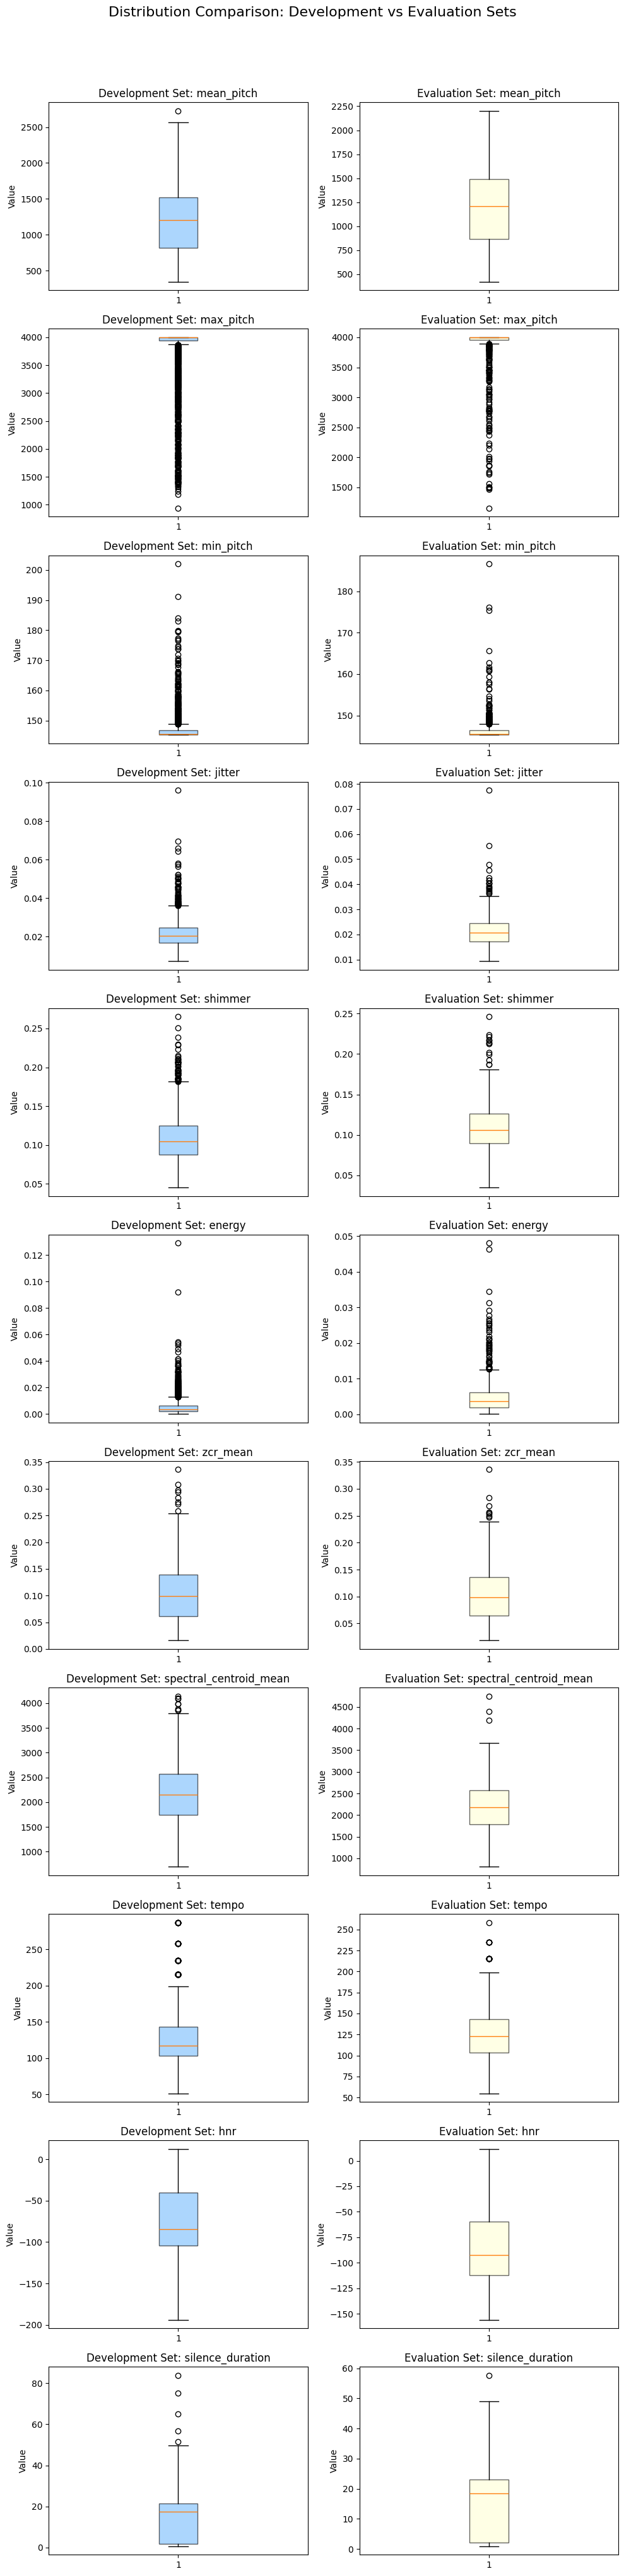

In [92]:
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 40))
plt.suptitle("Distribution Comparison: Development vs Evaluation Sets", fontsize=16, y=1.02)

for i, feature in enumerate(NUMERICAL_FEATURES):
    dev_data = df_dev_copy[feature]
    eval_data = df_eval_copy[feature]
    
    # Development set boxplot
    bp1 = axes[i, 0].boxplot(dev_data, patch_artist=True)
    axes[i, 0].set_title(f"Development Set: {feature}", fontsize=12)
    axes[i, 0].set_ylabel("Value")
    
    # Customize dev set boxplot colors
    bp1['boxes'][0].set_facecolor('xkcd:sky blue')
    bp1['boxes'][0].set_alpha(0.6)
    
    # Evaluation set boxplot
    bp2 = axes[i, 1].boxplot(eval_data, patch_artist=True)
    axes[i, 1].set_title(f"Evaluation Set: {feature}", fontsize=12)
    axes[i, 1].set_ylabel("Value")
    
    # Customize eval set boxplot colors
    bp2['boxes'][0].set_facecolor('xkcd:eggshell')
    bp2['boxes'][0].set_alpha(0.6)

plt.tight_layout()
plt.show()

# Data Pipeline

In [153]:
X, y = df_dev_copy.drop(columns=["target"]), df_dev_copy["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

**Development Data (vanilla)**

In [154]:
# transformation from ethnicity to binary column representing igbo ethnicity
class EthnicityBinarization(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        data = X.copy() 
        data = (data == "igbo").astype(int) 
        
        return data
    
    def get_feature_names_out(self, input_features=None):
        return ["is_igbo"]


In [159]:
vanilla_transformation = ColumnTransformer(
    transformers=[
        ("is_igbo", EthnicityBinarization(), ["ethnicity"]),
        ("ohe_gender", OneHotEncoder(categories="auto", drop="first", handle_unknown="ignore"), ["gender"]),
        ("ss_scaler", StandardScaler(), ["mean_pitch", "max_pitch", "min_pitch",
                                         "jitter", "shimmer", "energy", "zcr_mean", 
                                         "spectral_centroid_mean","tempo","hnr", "silence_duration"]),
        ("mm_scaler", MinMaxScaler(), ["num_words", "num_characters", "num_pauses"])
    ],
    remainder="drop",
    verbose_feature_names_out=False,
    sparse_threshold=0
)

In [ ]:
X_train_transformed = pd.DataFrame(vanilla_transformation.fit_transform(X_train), columns=vanilla_transformation.get_feature_names_out())
X_train_transformed.head()

,is_igbo,gender_male,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,silence_duration,num_words,num_characters,num_pauses
0,0.0,1.0,1.048997,0.405451,-0.229818,0.696296,0.499202,-0.297898,0.404231,0.666675,-0.378387,-0.842678,0.624120,1.000000,1.000000,0.104167
1,1.0,0.0,-0.528746,-0.948949,-0.332210,-1.288451,-0.359777,-0.490371,-0.873231,-0.740502,-1.242547,2.080306,-1.170278,0.057971,0.042705,0.000000
2,0.0,0.0,1.467469,0.405453,-0.367300,-0.525279,-0.041642,-0.098644,1.744970,1.857439,-0.646277,-0.115711,0.572994,1.000000,1.000000,0.000000
3,0.0,0.0,0.362234,0.403375,0.102077,0.324092,0.268961,0.001486,0.356656,-0.223268,-0.226177,-0.518026,0.288579,1.000000,1.000000,0.270833
4,1.0,1.0,-1.400286,-0.319881,0.963761,-0.265006,0.091250,0.126048,-1.387614,-1.555035,-0.226177,0.930697,-1.088583,0.101449,0.067616,0.000000


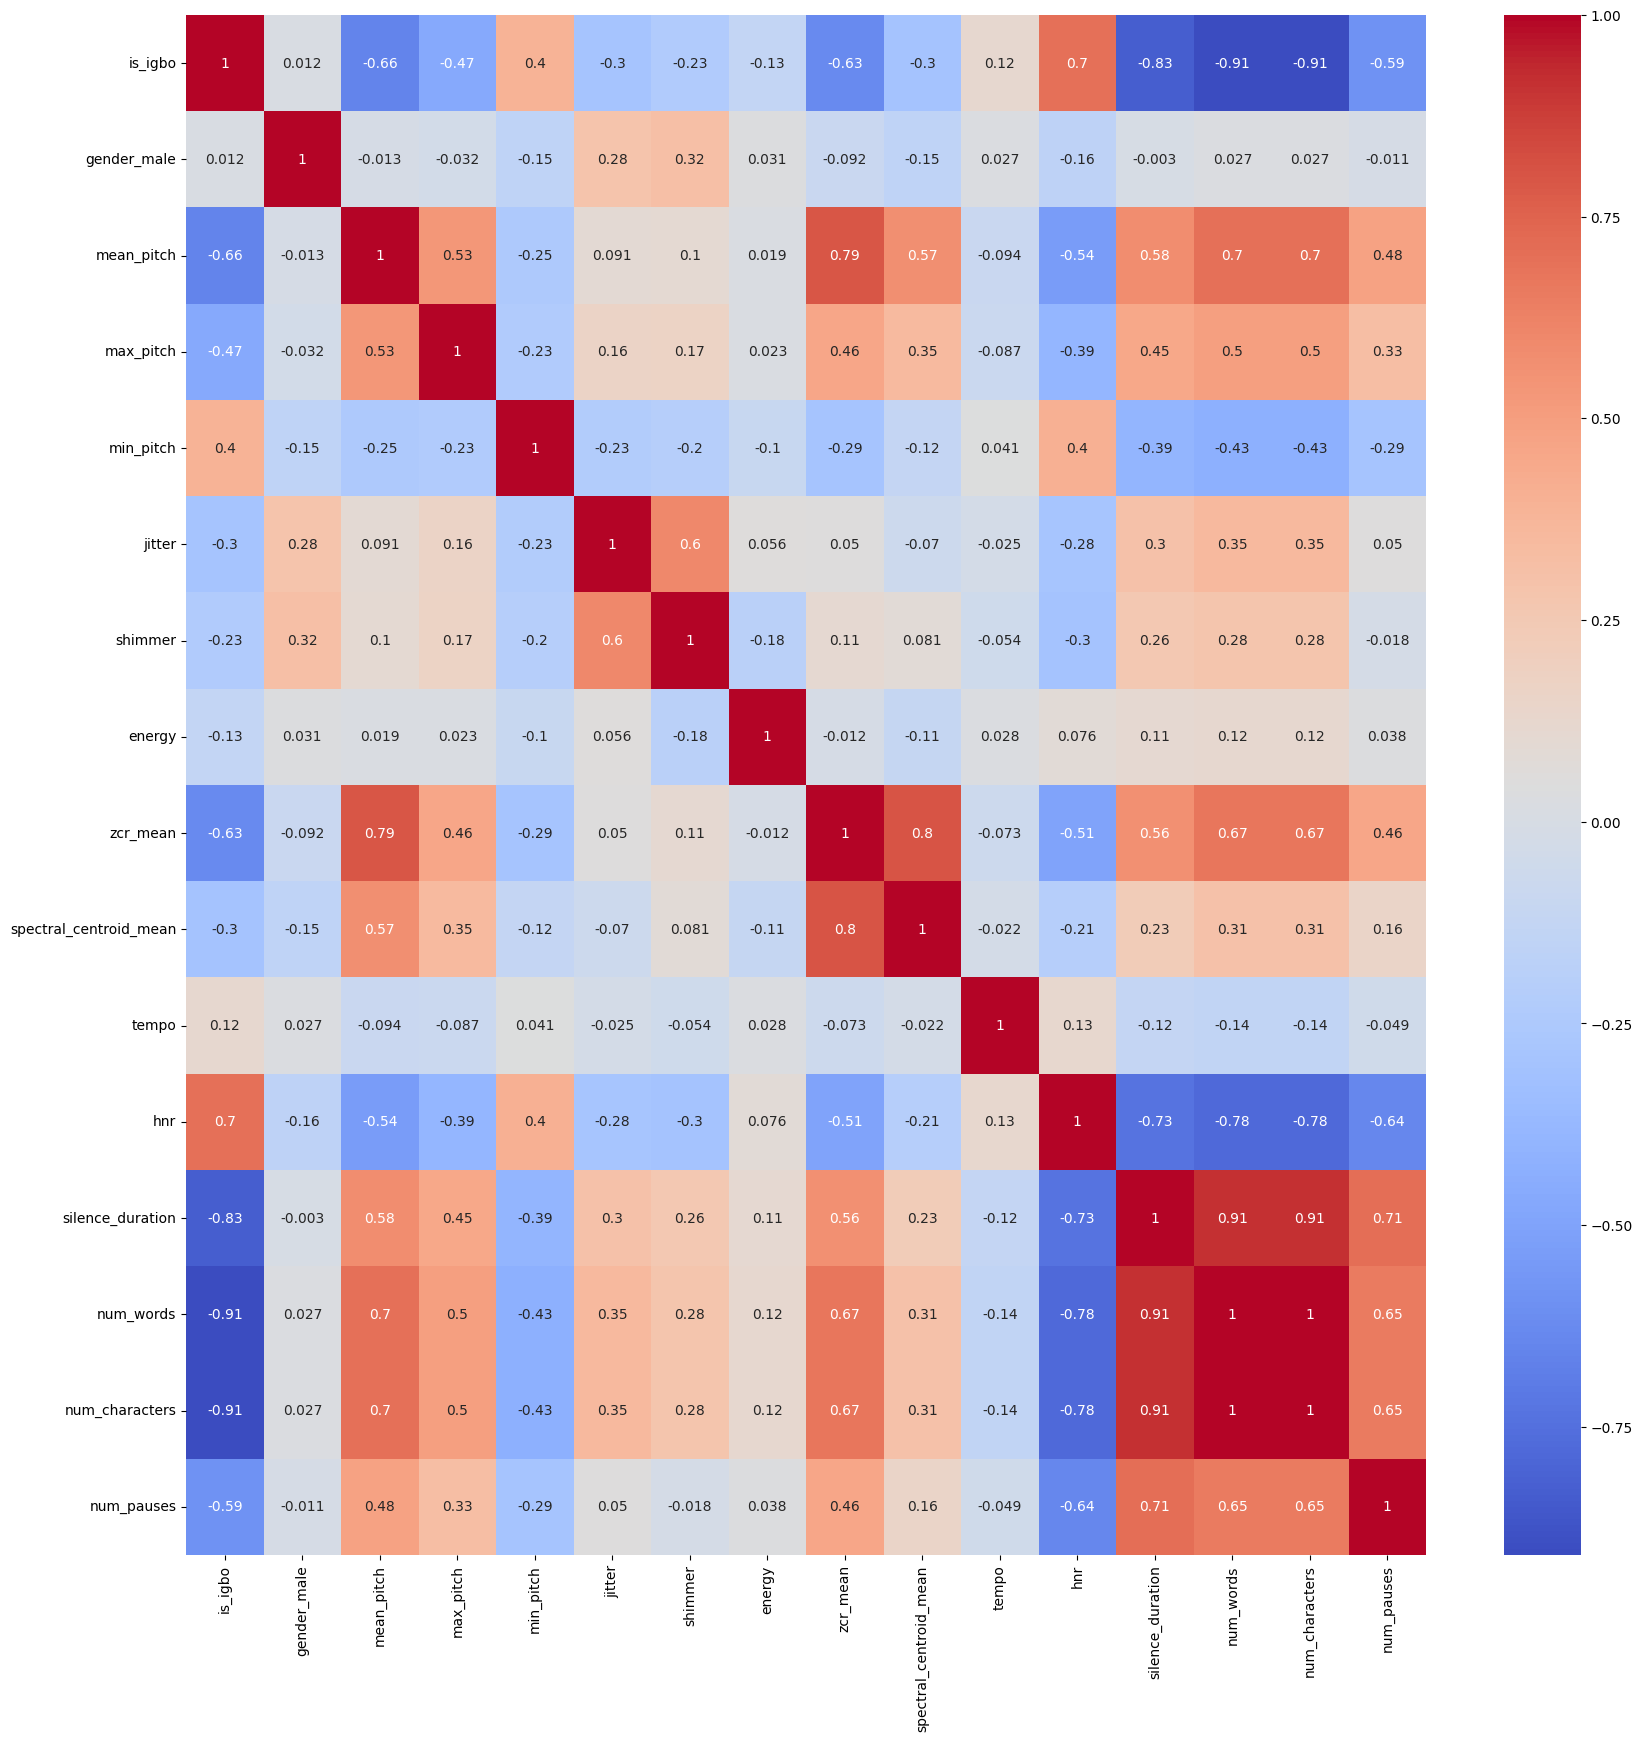

In [161]:
corr = X_train_transformed.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.show()

In [162]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train_transformed, y_train)
rmse_1 = root_mean_squared_error(y_true=y_test, y_pred=reg.predict(vanilla_transformation.transform(X_test)))
print(rmse_1)

10.443431001826855


c:\Users\andre\Documents\University\1st Year\Data Science Lab process and methods (2024-25)\final_project\DSL-Age-Estimation\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [163]:
sorted(zip(X_train_transformed.columns, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('silence_duration', np.float64(0.3252578734524007)),
 ('jitter', np.float64(0.07256336996861892)),
 ('spectral_centroid_mean', np.float64(0.06383096550809844)),
 ('zcr_mean', np.float64(0.0619107023425054)),
 ('shimmer', np.float64(0.06168526692943519)),
 ('max_pitch', np.float64(0.06047639748992454)),
 ('min_pitch', np.float64(0.05983057251001696)),
 ('hnr', np.float64(0.05970499207242324)),
 ('mean_pitch', np.float64(0.05899234185648698)),
 ('num_pauses', np.float64(0.05891589565751415)),
 ('energy', np.float64(0.057496181182417366)),
 ('tempo', np.float64(0.044927604890730354)),
 ('gender_male', np.float64(0.010659480523184302)),
 ('num_words', np.float64(0.0013363377081649155)),
 ('num_characters', np.float64(0.001237054055479173)),
 ('is_igbo', np.float64(0.001174963852599401))]

In [226]:
def feature_importance_analysis(path):
    df = pd.read_csv(path)
    df.drop(columns=["file_name"], inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(df, y, shuffle=True, random_state=42)
    pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(100, random_state=42))
    pipeline.fit(X_train, y_train)
    predict = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_true=y_test, y_pred=predict)

    feat_importance = sorted(zip(df.columns, pipeline[-1].feature_importances_), key=lambda x: x[1], reverse=True)

    print(f"RMSE: {rmse}\n")
    print("Top 10 Features\n:")
    for col in feat_importance[:10]:
        print(col)
    

def correlation_plot(path):
    data = pd.read_csv(path)
    data.drop(columns=["file_name", "Id"], inplace=True)
    columns = data.columns

    ss_data = pd.DataFrame(StandardScaler().fit_transform(data), columns=columns)
    corr = ss_data.corr()
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, cmap="coolwarm")
    plt.show()

In [227]:
def evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred, root_mean_squared_error(y_test, y_pred), model

In [228]:
def test(df_dev, df_eval):    
    def process_audio(df):
        return df.drop(columns=["file_name"])

    if 'file_name' in df_dev.columns:
        df_dev = process_audio(df_dev)
        df_eval = process_audio(df_eval)
    ss = StandardScaler()

    X_train_transformed = pd.DataFrame(ss.fit_transform(df_dev), columns=df_dev.columns)
    X_train_transformed = X_train_transformed.drop(columns=["Id"])    

    X_test_transformed = ss.transform(df_eval)

    X_train, X_valid, y_train, y_valid = train_test_split(X_train_transformed, y, random_state=42)
    _, rmse, reg = evaluate_model(X_train, y_train, X_valid, y_valid, RandomForestRegressor(random_state=42))
    print(rmse)
    display(sorted(zip(X_train_transformed.columns, reg.feature_importances_), key=lambda x: x[1],reverse=True))

    corr = X_train_transformed.corr()
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, cmap="coolwarm", annot=False)
    plt.show()

**Spectral Data**

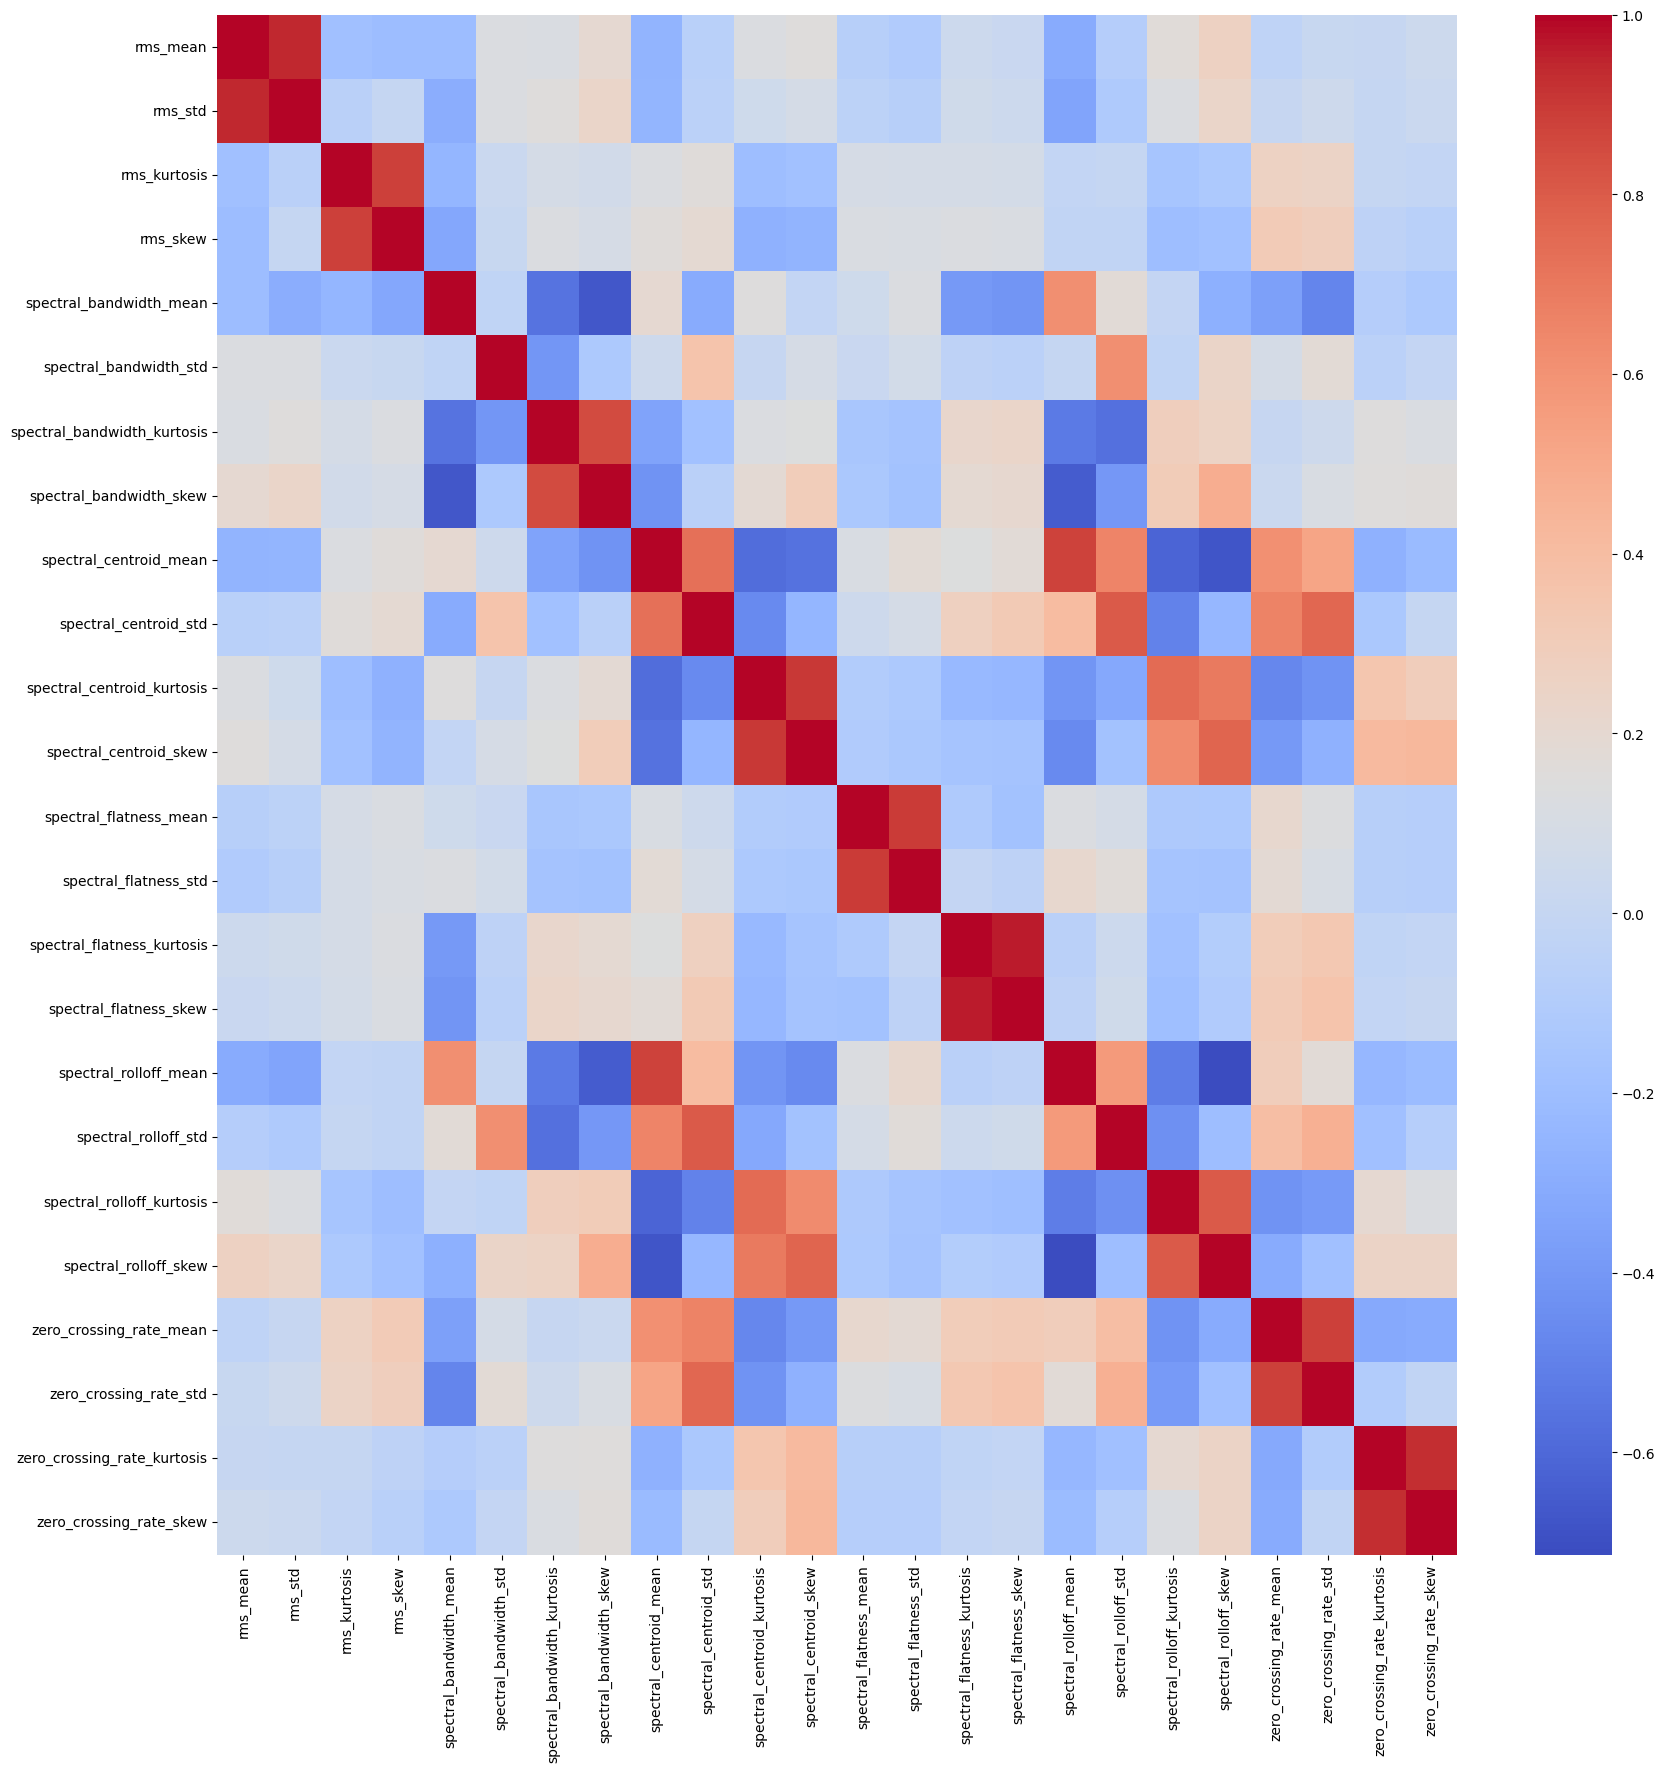

In [229]:
correlation_plot("data/dev_spectral_audio_features.csv")

In [230]:
feature_importance_analysis(path="data/dev_spectral_audio_features.csv")

RMSE: 11.008114985688836

Top 10 Features
:
('spectral_bandwidth_mean', np.float64(0.2423024347295328))
('zero_crossing_rate_mean', np.float64(0.04188644822266973))
('zero_crossing_rate_skew', np.float64(0.04106930904235928))
('zero_crossing_rate_kurtosis', np.float64(0.04102698874344541))
('spectral_flatness_std', np.float64(0.040288579669745896))
('spectral_flatness_mean', np.float64(0.040057504812989184))
('Id', np.float64(0.03725046250421032))
('spectral_bandwidth_skew', np.float64(0.03628874945268732))
('zero_crossing_rate_std', np.float64(0.03473664897038311))
('rms_std', np.float64(0.031848131454271345))


**Spectral Contrast**

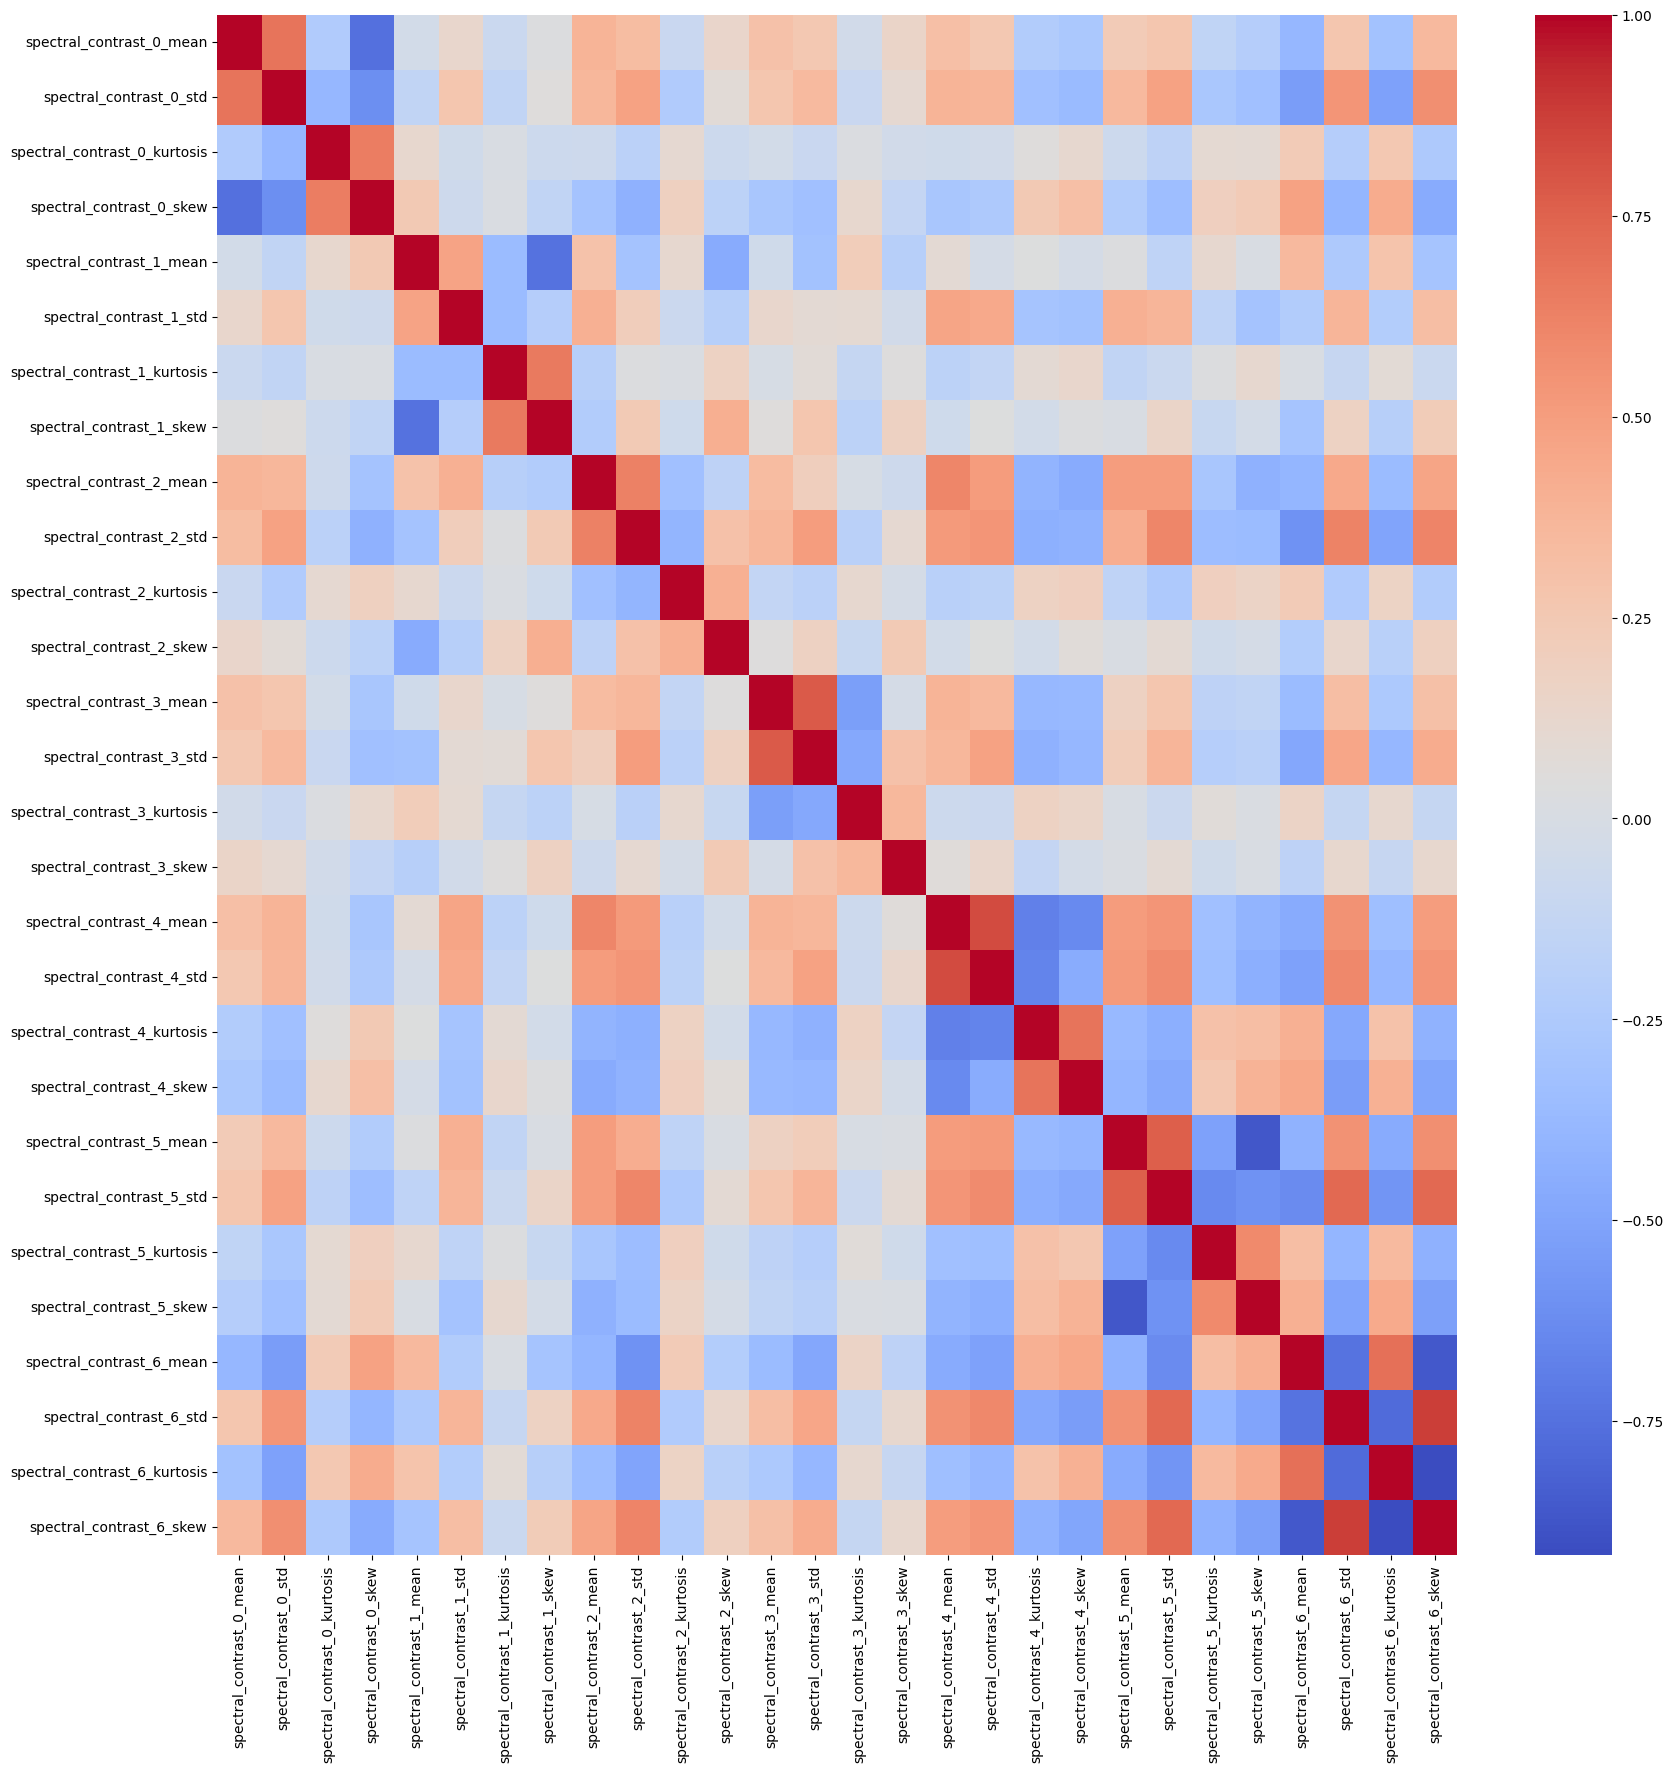

In [231]:
correlation_plot("data/dev_spectral_contrast_audio_features.csv")

In [232]:
feature_importance_analysis("data/dev_spectral_contrast_audio_features.csv")

RMSE: 10.789878119000615

Top 10 Features
:
('spectral_contrast_6_kurtosis', np.float64(0.19668039645262284))
('spectral_contrast_0_std', np.float64(0.06282295958341393))
('spectral_contrast_0_skew', np.float64(0.04815072472673604))
('spectral_contrast_6_std', np.float64(0.04531788936973954))
('spectral_contrast_3_std', np.float64(0.03845606205759712))
('spectral_contrast_3_mean', np.float64(0.03632100246658746))
('spectral_contrast_5_std', np.float64(0.034150145544800545))
('spectral_contrast_4_mean', np.float64(0.03249944866145811))
('spectral_contrast_4_std', np.float64(0.0319574387340495))
('spectral_contrast_4_kurtosis', np.float64(0.030701617538233278))


**Melspectrogram Data**

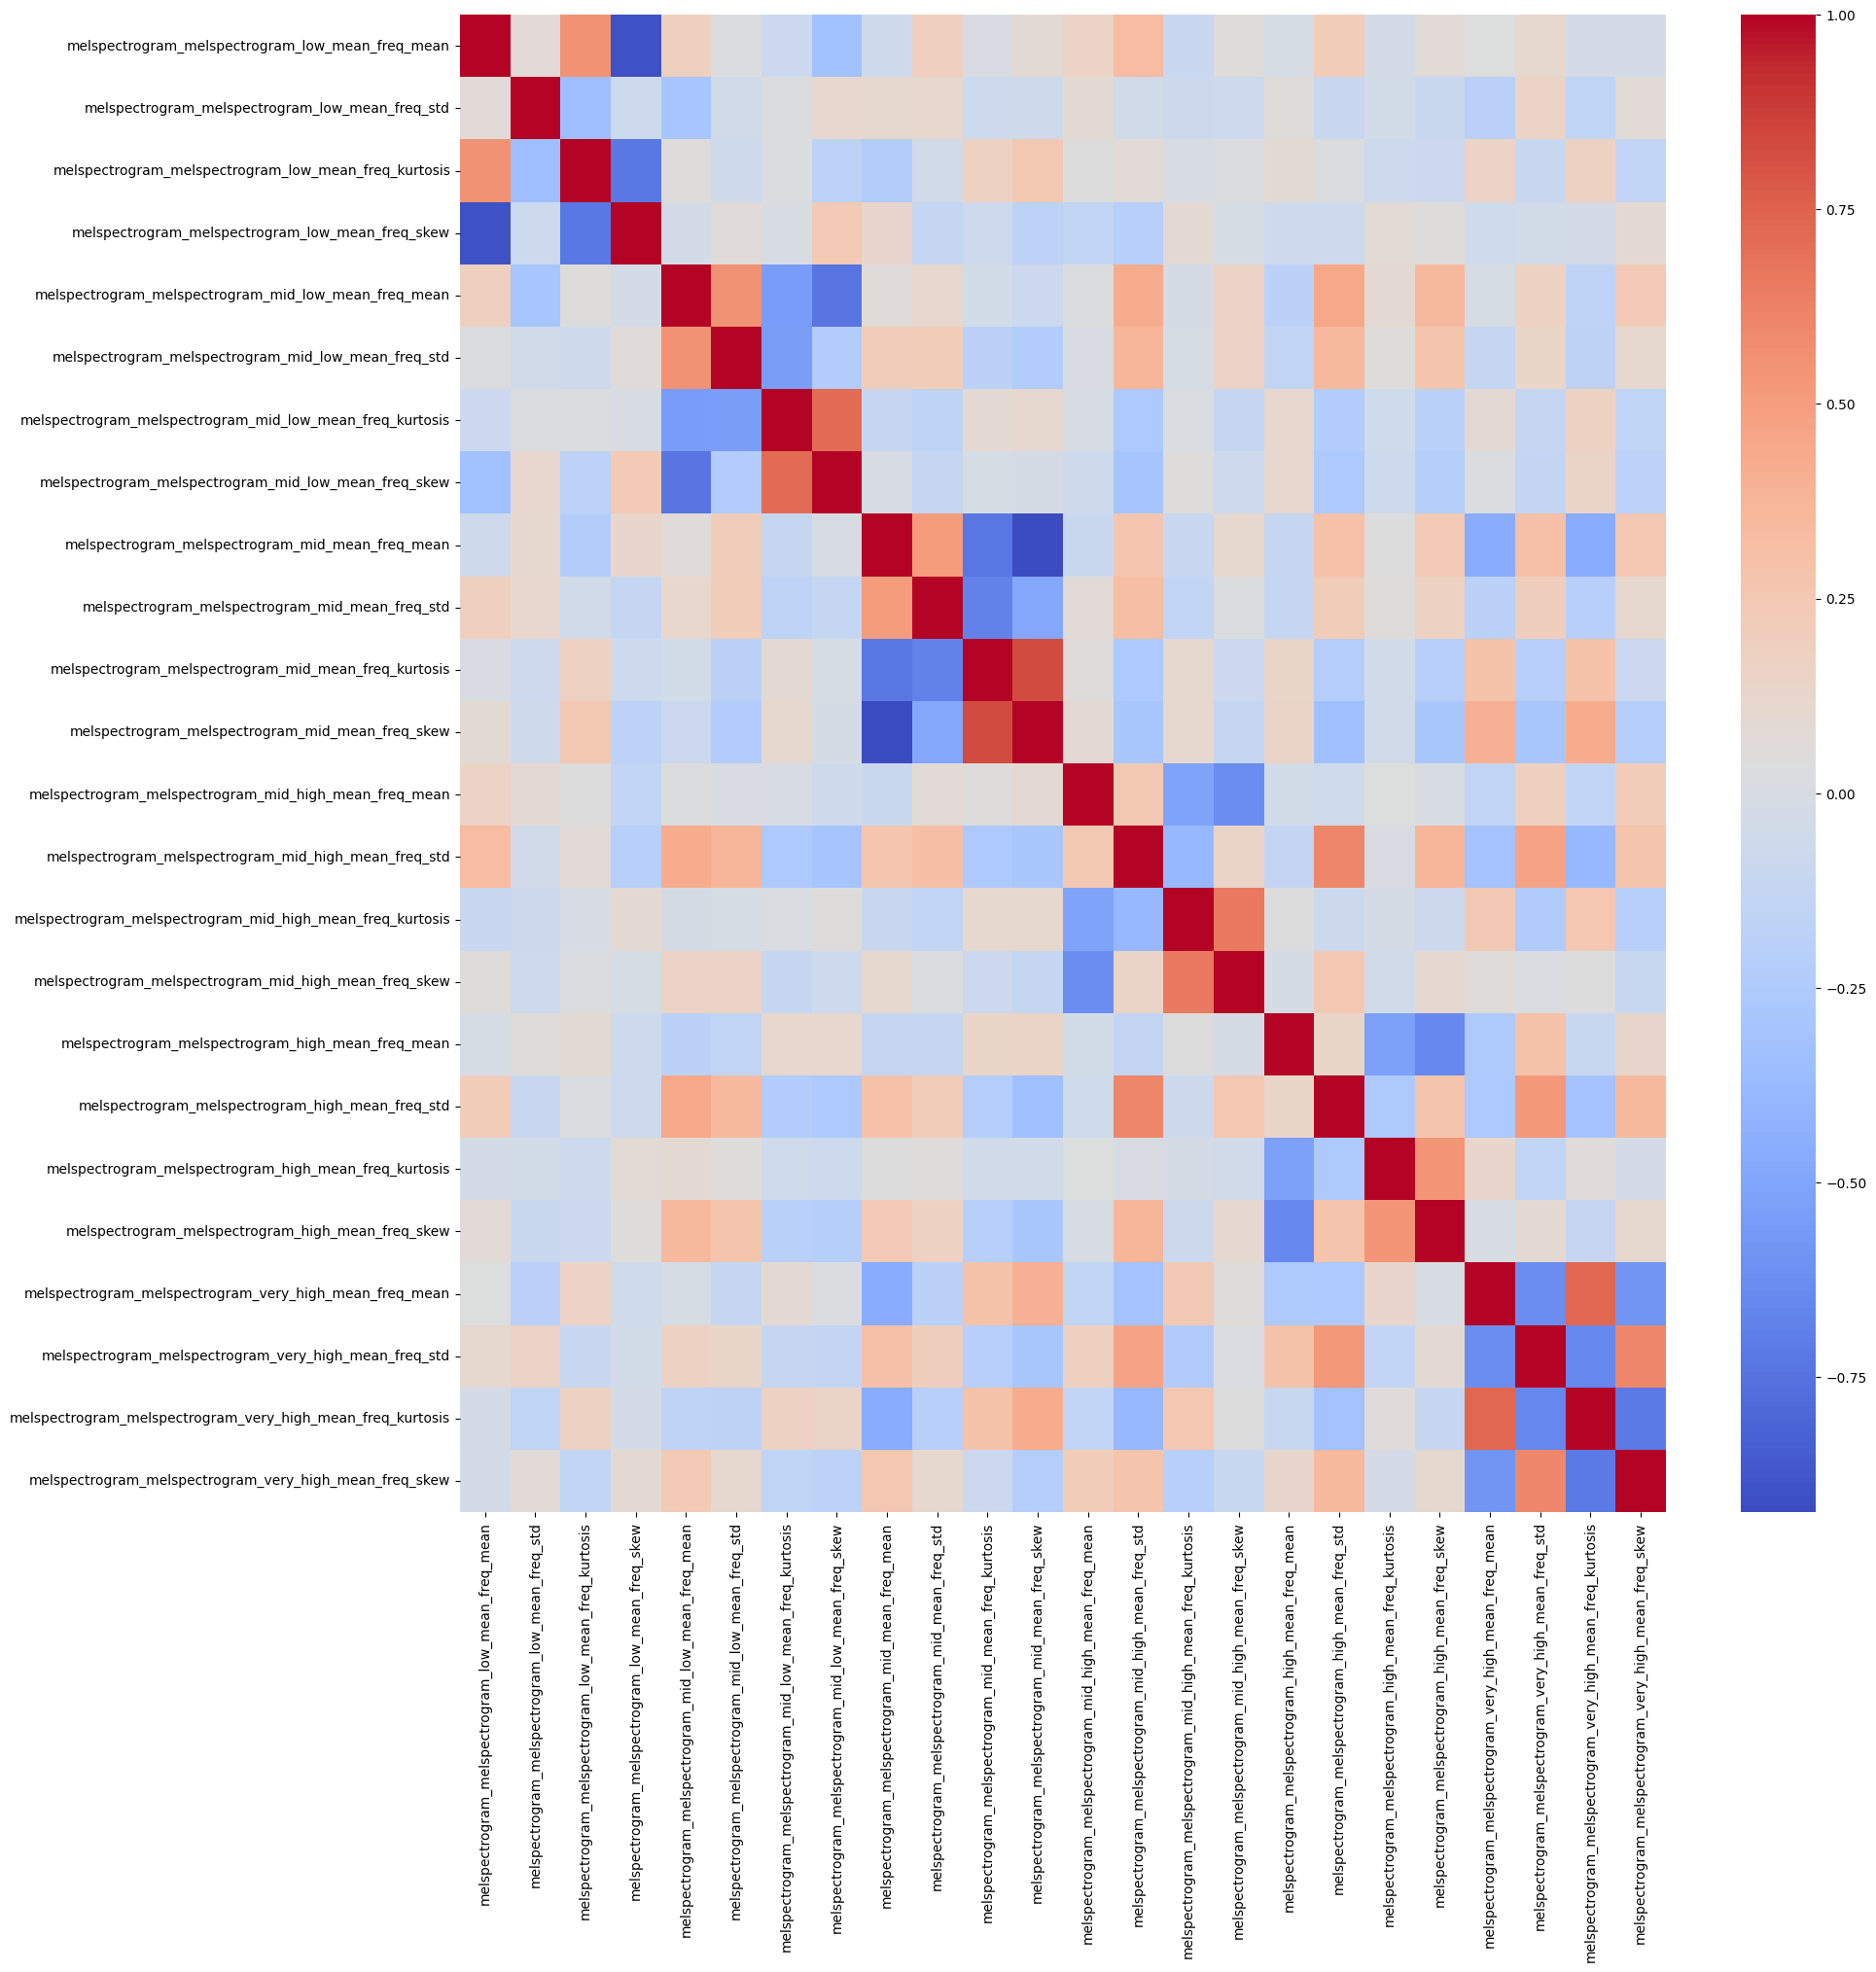

In [233]:
correlation_plot("data/dev_melspectrogram_audio_features.csv")

In [234]:
feature_importance_analysis(path="data/dev_melspectrogram_audio_features.csv")

RMSE: 10.885362877090504

Top 10 Features
:
('melspectrogram_melspectrogram_high_mean_freq_std', np.float64(0.13113069282379008))
('melspectrogram_melspectrogram_high_mean_freq_mean', np.float64(0.12441607216291097))
('melspectrogram_melspectrogram_mid_low_mean_freq_mean', np.float64(0.07270966253698015))
('melspectrogram_melspectrogram_mid_mean_freq_std', np.float64(0.06550408923363063))
('melspectrogram_melspectrogram_mid_high_mean_freq_std', np.float64(0.035685846133369274))
('melspectrogram_melspectrogram_mid_low_mean_freq_std', np.float64(0.03518189127634444))
('melspectrogram_melspectrogram_mid_high_mean_freq_mean', np.float64(0.03358248707564125))
('melspectrogram_melspectrogram_low_mean_freq_std', np.float64(0.03350965354954175))
('melspectrogram_melspectrogram_mid_low_mean_freq_kurtosis', np.float64(0.03283234017990888))
('melspectrogram_melspectrogram_very_high_mean_freq_mean', np.float64(0.03257350346537566))


**MFCCs & Deltas**

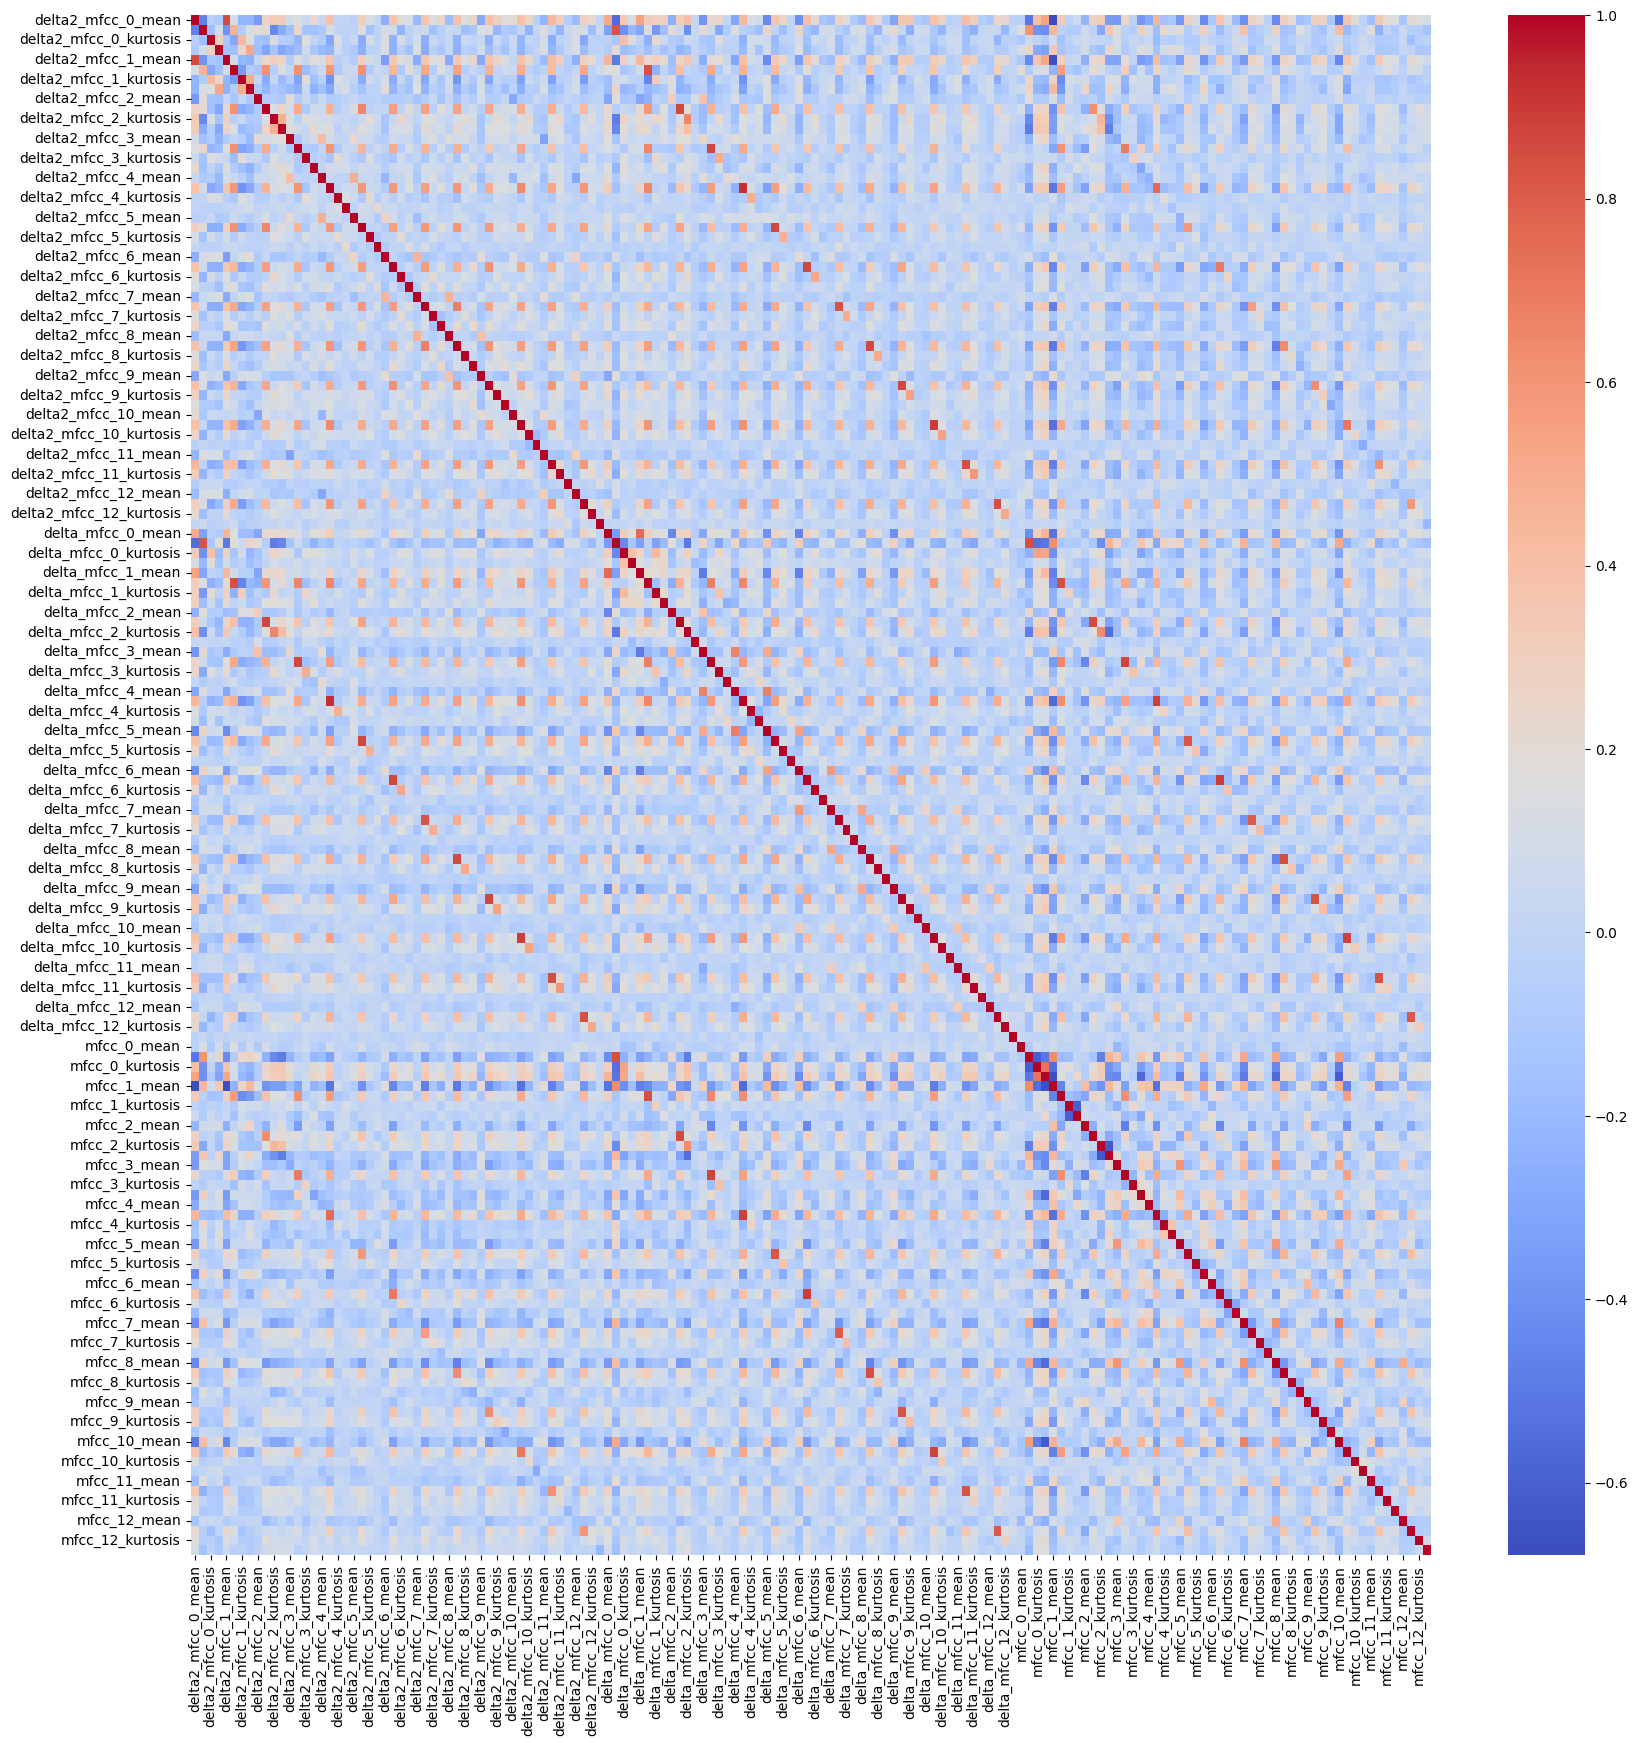

In [235]:
correlation_plot("data/dev_mfcc_deltas_audio_features.csv")

In [236]:
feature_importance_analysis("data/dev_mfcc_deltas_audio_features.csv")

RMSE: 10.146352769501007

Top 10 Features
:
('delta2_mfcc_0_mean', np.float64(0.09942702586895781))
('mfcc_10_mean', np.float64(0.06564911013731306))
('mfcc_0_skew', np.float64(0.05708065339845276))
('delta_mfcc_1_skew', np.float64(0.0357620095796527))
('delta2_mfcc_0_std', np.float64(0.03194008514619755))
('delta2_mfcc_4_std', np.float64(0.0239589736151559))
('mfcc_8_mean', np.float64(0.01217913330169041))
('mfcc_1_mean', np.float64(0.009976654644526952))
('delta2_mfcc_12_kurtosis', np.float64(0.009779665412004878))
('delta2_mfcc_9_skew', np.float64(0.0097341261568978))


# Model Selection

In [80]:
def evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred, root_mean_squared_error(y_test, y_pred)

In [81]:
df_dev = preprocess_and_transform_columns(df_dev)
df_eval = preprocess_and_transform_columns(df_eval)

df_audio_dev = preprocess_and_transform_audio_columns(df_audio_dev)
df_audio_eval = preprocess_and_transform_audio_columns(df_audio_eval)

df_dev = df_dev.join(df_audio_dev)
df_eval = df_eval.join(df_audio_eval)

In [82]:
X, y = df_dev.drop(columns=["target"]), df_dev["target"]
X.shape, y.shape

((2933, 105), (2933,))

In [34]:
for col in X.columns:
    aux = (X[col].value_counts() == 1)
    if 0 < aux.sum() < 50:
        print(f"{col}: number of possible outliers: {(X[col].value_counts() == 1).sum()}:")
        print(f"\t{X[col].unique()[aux]}")

tempo: number of possible outliers: 4:
	[57.421875   52.734375   51.6796875  63.02400915]
num_words: number of possible outliers: 2:
	[12 10]
num_characters: number of possible outliers: 4:
	[23 41 18 26]
num_pauses: number of possible outliers: 12:
	[49 69 83 81 58 75 97 78 67 77 64 68]


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_d = make_pipeline(
    final_transformation,
    # StandardScaler(),
    # PCA(n_components=0.8),   
)

X_train = pipeline_d.fit_transform(X_train)
X_test = pipeline_d.transform(X_test)

reg = RandomForestRegressor()
_, rmse = evaluate_model(X_train, y_train, X_test, y_test, reg)
rmse

9.63775839289737

In [84]:
from prettytable import PrettyTable
random_state = 42

def evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred, root_mean_squared_error(y_test, y_pred)

degree = 2
models = [
    LinearRegression(),
    Lasso(),
    Ridge(random_state=random_state),
    MLPRegressor(hidden_layer_sizes=(10,), random_state=random_state, max_iter=10000),
    MLPRegressor(hidden_layer_sizes=(10,10),  activation='tanh', solver='lbfgs',
                 alpha=0.000, batch_size='auto', learning_rate='constant',
                 learning_rate_init=0.01, power_t=0.5, max_iter=10000, shuffle=True,
                 random_state=random_state, tol=0.0001, verbose=True, warm_start=False,
                 momentum=0.0, nesterovs_momentum=False, early_stopping=False,
                 validation_fraction=0.0, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    SVR(gamma='scale'),
    RandomForestRegressor(n_estimators=300),
    # make_pipeline(
    #     PolynomialFeatures(degree),
    #     LinearRegression()
    # ),
    # make_pipeline(
    #     PolynomialFeatures(degree),
    #     Ridge(alpha=1)
    # )
]

names = [
    'linreg',
    'lasso',
    'ridge',
    'mlp_standard',
    'mlp_tuned',
    'svr',
    'rf',
    # f'poly{degree}+linreg',
    # f'poly{degree}+ridge'
]


t = PrettyTable()
t.field_names = ['model', 'RMSE']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training set into training and validation sets
# X_train_valid, X_test, y_train_valid, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

pipeline_d = make_pipeline(
    final_transformation,
    StandardScaler(),
    PCA(n_components=0.9),   
)

X_train = pipeline_d.fit_transform(X_train)
X_test = pipeline_d.transform(X_test)

for model, name in zip(models, names):
    # print(name)
    _, rmse = evaluate_model(X_train, y_train, X_test, y_test, model)
    t.add_row([name, rmse])

print(t)

C:\Users\danie\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


+--------------+--------------------+
|    model     |        RMSE        |
+--------------+--------------------+
|    linreg    | 10.158096169375744 |
|    lasso     | 10.719522535314859 |
|    ridge     | 10.158200226582732 |
| mlp_standard | 10.099150120540125 |
|  mlp_tuned   | 13.41257273847359  |
|     svr      | 11.002195563615915 |
|      rf      | 10.15004692077077  |
+--------------+--------------------+


In [35]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
model_pipeline = IMBPipeline(
    [   
        ("trans", final_transformation),
        ("dim_reduction", PCA(n_components=.8)),
        ("classifier", LinearRegression())
    ]
)

In [37]:
model_pipeline.fit(X_train, y_train)
prediction = model_pipeline.predict(X_test)

root_mean_squared_error(y_true=y_test, y_pred=prediction)

10.494675623384339

In [38]:
# sampler_configs = [
#     {
#         "sampler": [None]
#     },
#     {
#         "sampler": [RandomOverSampler(random_state=42)],
#         "sampler__sampling_strategy": ["minority",  "not majority", "all", "auto"]
#     },
#     {
#         "sampler": [RandomUnderSampler(random_state=42)],
#         "sampler__sampling_strategy": ["majority", "not minority", "all", "auto"]
#     },
#     {
#         "sampler": [TomekLinks()],
#         "sampler__sampling_strategy": ["majority", "not minority", "not majority", "all", "auto" ]
#     }
# ]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA(random_state=42)],
        'dim_reduction__n_components': [0.8, 0.9, 0.95, 0.99]
    }
]

classifier_configs = [
    {
        "classifier": [LinearRegression()],
        "classifier__fit_intercept": [True, False]
    },
    {
        "classifier": [RandomForestRegressor(random_state=42, n_jobs=-1)],
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 5, 10],
        "classifier__min_samples_split": [2, 5]
    },
    {
        "classifier": [Ridge(random_state=42)],
        "classifier__alpha": [0.01, 0.1, 1.0, 10.0],
        "classifier__fit_intercept": [True, False]
    },
    {
        "classifier": [Lasso(random_state=42)],
        "classifier__alpha": [0.01, 0.1, 1.0, 10.0],
        "classifier__fit_intercept": [True, False]
    },
    {
        "classifier": [GradientBoostingRegressor(random_state=42)],
        "classifier__n_estimators": [100, 200],
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__max_depth": [3, 5]
    },
]

In [39]:
import itertools

all_configs = []
for configuration in itertools.product(dim_reduction_configs, 
                                       classifier_configs):
    all_configs.append((dict(itertools.chain(*(e.items() for e in configuration)))))
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 10'

In [40]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 5,
    scoring='neg_root_mean_squared_error'
)

In [41]:
scores = cross_validate(rs, X_train, y_train, scoring='neg_root_mean_squared_error', cv = 5, return_estimator=True, verbose=1) 


C:\Users\danie\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [45]:
print('#'*100)
for index, estimator in enumerate(scores['estimator']):
    #print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('- '*100)

####################################################################################################
None
RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
-10.137639379108485
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
None
GradientBoostingRegressor(random_state=42) {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 

In [46]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    rmse_train = root_mean_squared_error(y_train, pred_train)
    rmse_test = root_mean_squared_error(y_test, pred_test)
    print(f'RMSE on training set:{rmse_train}, RMSE on test set:{rmse_test}')

RMSE on training set:3.960763415349906, RMSE on test set:9.550878537325923
RMSE on training set:7.389966259192815, RMSE on test set:9.390861814680383
RMSE on training set:4.353103658812687, RMSE on test set:9.49156741609539
RMSE on training set:9.214431287051504, RMSE on test set:9.94315114479936
RMSE on training set:7.389966259192815, RMSE on test set:9.390861814680383


In [47]:
predictions = list()
for estimator in scores['estimator']:
    estimator.best_estimator_.fit(X, y)
    predictions.append(estimator.best_estimator_.predict(df_eval))

predictions

[array([38.45  , 40.    , 22.97  , 34.2475, 36.145 , 25.785 , 25.955 ,
        19.75  , 34.07  , 22.47  , 46.9825, 19.985 , 38.525 , 20.03  ,
        38.145 , 30.74  , 41.87  , 32.53  , 28.505 , 24.735 , 33.2725,
        40.5675, 48.2   , 31.21  , 35.6   , 34.8   , 25.6075, 21.865 ,
        32.4225, 27.395 , 27.53  , 40.145 , 25.92  , 19.515 , 39.16  ,
        21.13  , 21.4   , 36.3625, 19.67  , 24.87  , 21.06  , 24.665 ,
        39.2625, 38.22  , 48.69  , 36.285 , 41.125 , 32.275 , 22.5   ,
        32.02  , 38.415 , 24.45  , 33.41  , 25.84  , 32.96  , 29.875 ,
        29.5575, 33.465 , 29.88  , 27.125 , 21.16  , 21.67  , 35.39  ,
        20.805 , 28.545 , 32.4875, 18.15  , 23.31  , 23.78  , 36.73  ,
        24.295 , 19.015 , 32.155 , 23.74  , 36.565 , 43.045 , 35.17  ,
        28.145 , 19.77  , 26.1175, 22.6   , 31.6   , 37.25  , 31.45  ,
        20.085 , 45.315 , 20.25  , 26.77  , 23.735 , 20.795 , 38.005 ,
        19.32  , 18.62  , 35.215 , 19.1   , 19.44  , 23.415 , 39.0125,
      

In [48]:
ids = df_eval.index

for i, pred in enumerate(predictions):
    res = pd.DataFrame({'Id': ids, 'Predicted': pred})
    res.to_csv(f'submissions/submission_{i}.csv', sep=',', index=False)

## Results